The main idea is to use the calibrated efficiency in order to predict the UV and Halpha luminosities. 



# Setup environment

In [1]:
# read in modules

import astropy.units as u
from astropy.table import Table
from hmf import MassFunction
import os



In [7]:
# define paths
       
path_main = os.environ['WDIR_halo_model']
path_figures = path_main + 'Figures/Tests/'
path_DM_cat = path_main + 'catalogs/DM/'
path_SFH_cat = path_main + 'catalogs/SFH/'



# Setup SFHs (we have to run this once => save output)

Input:   DM halo accretion history, as given by hdf5 files

Output:  added SFH to the hdf5 files?



In [82]:
import numpy as np
import h5py
import os

import read_in_halo_cat
import read_in_efficency
import make_SFH

from astropy.cosmology import WMAP7 as cosmo

import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'STIXGeneral'




In [83]:
# define paths

path_main = os.environ['WDIR_halo_model']
path_figures = path_main + 'Figures/Tests/'
path_DM_cat = path_main + 'catalogs/DM/'
path_SFH_cat = path_main + 'catalogs/SFH/'



In [84]:
# set parameters

DM_accretion_history_filename = 'MergerHistory_COLOR_CDM_z3.96.hdf5'
efficency_filename = 'Calibration/epsilon.npy'
SFH_type_option = 'random'
filename_SFH_file = 'SFH_random.hdf5'


In [85]:
# get dark matter accretion history

z_table_in, M_table_in, Mt_table_in = read_in_halo_cat.read_in_halo_cat(path_DM_cat + DM_accretion_history_filename, cosmo)

print len(z_table_in)
print len(M_table_in)
print len(Mt_table_in)


72
167276
167276


In [86]:
# set up efficency function (based on calibration)

epsilon_efficency_fct = read_in_efficency.read_in_efficency(path_SFH_cat + efficency_filename)


In [87]:
# get SFH: random burst in last step

t_snapshots = 10**3*cosmo.age(z_table_in).value  # in Myr  

# loop over all halos

for idx_h in range(len(M_table_in))[::1000]:
    print 'progress (%): ', round(100.0*idx_h/len(M_table_in), 3)
    time_list, SFR_list = make_SFH.construct_SFH(Mt_table_in[idx_h], t_snapshots, look_back=round(t_snapshots[0]), dt=0.1, SFH_type=SFH_type_option, epsilon_fct=epsilon_efficency_fct)
    if (idx_h == 0):
        SFH_table_SFR = SFR_list
    else:
        SFH_table_SFR = np.vstack([SFH_table_SFR, SFR_list])



progress (%):  0.0
progress (%):  0.598
progress (%):  1.196
progress (%):  1.793
progress (%):  2.391
progress (%):  2.989
progress (%):  3.587
progress (%):  4.185
progress (%):  4.783
progress (%):  5.38
progress (%):  5.978
progress (%):  6.576
progress (%):  7.174
progress (%):  7.772
progress (%):  8.369
progress (%):  8.967
progress (%):  9.565
progress (%):  10.163
progress (%):  10.761
progress (%):  11.358
progress (%):  11.956
progress (%):  12.554
progress (%):  13.152
progress (%):  13.75
progress (%):  14.348
progress (%):  14.945
progress (%):  15.543
progress (%):  16.141
progress (%):  16.739
progress (%):  17.337
progress (%):  17.934
progress (%):  18.532
progress (%):  19.13
progress (%):  19.728
progress (%):  20.326
progress (%):  20.924
progress (%):  21.521
progress (%):  22.119
progress (%):  22.717
progress (%):  23.315
progress (%):  23.913
progress (%):  24.51
progress (%):  25.108
progress (%):  25.706
progress (%):  26.304
progress (%):  26.902
progress (%

In [88]:
# save SFH
try:
    os.remove(path_SFH_cat + filename_SFH_file)
except OSError:
    pass

f = h5py.File(path_SFH_cat + filename_SFH_file, 'w')
# add SFH
grp_SFH = f.create_group("SFH")
grp_SFH.create_dataset('SFH_time', data=time_list)
grp_SFH.create_dataset('SFH_SFR', data=SFH_table_SFR)
# add DM assembly
grp_DM = f.create_group("DM")
grp_DM.create_dataset('DM_time', data=t_snapshots)
grp_DM.create_dataset('DM_z', data=z_table_in)
grp_DM.create_dataset('DM_M', data=M_table_in)
grp_DM.create_dataset('DM_Mt', data=Mt_table_in)
f.close()


# Compute Luminosities (UV, Halpha, etc.)

We start with a fiducial model:
- IMF         :   Salpeter (imf_type=0)
- metallicity :   solar metallicity (logzsol=0.0)
- dust        :   average beta relation

Possible variations:
- IMF         : 
                * 0: Salpeter (1955)
                * 1: Chabrier (2003)
                * 2: Kroupa (2001)
                * 3: van Dokkum (2008)
                * 4: Dave (2008)
                * 5: tabulated piece-wise power law IMF
- metallicity : simple grid
- dust        : apply scatter; add dust to nebular in some peculiar way ("fudge factor" of 0.44 to 1.00)

Things to keep in mind:
- stocastics effects at very low SFRs






In [1]:
import numpy as np
import h5py
import fsps
import itertools
import os

import derive_SP_prop


In [2]:
# define paths

path_main = os.environ['WDIR_halo_model']
path_figures = path_main + 'Figures/Tests/'
path_SFH_cat = path_main + 'catalogs/SFH/'
path_SP_cat = path_main + 'catalogs/SP/'



In [5]:
# set filename of SFH

filename_SFH_file = 'SFH_z4_random.hdf5'
filename_SP_file = 'SFH_z4_random_with_L.hdf5'


# fundge factor so that SFH setting works

idx_every_other = 2



In [28]:
# read in SFH
SFH_file = h5py.File(path_SFH_cat + filename_SFH_file, 'r')
SFH_time = SFH_file['SFH/SFH_time'][:]
SFH_SFR = SFH_file['SFH/SFH_SFR'][:]


In [30]:
SFH_file = h5py.File('/Users/sandrotacchella/Desktop/SFH_z4_random.hdf5', 'r')
SFH_time = SFH_file['SFH/SFH_time'][:]
SFH_SFR = SFH_file['SFH/SFH_SFR'][:]


In [31]:
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'STIXGeneral'


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


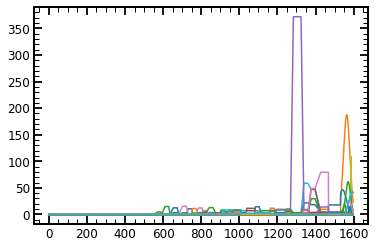

In [39]:
for ii in np.linspace(100, 200):
    plt.plot(SFH_time, SFH_SFR[ii], '-')
plt.show()

In [21]:
np.where(np.isnan(SFH_SFR[0]))

(array([1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1311,
        1316, 1328, 1331]),)

In [24]:
SFH_time

array([  5.00000000e-02,   1.50000000e-01,   2.50000000e-01, ...,
         1.43820000e+03,   1.45820000e+03,   1.47820000e+03])

In [17]:
np.min(SFH_SFR[0])

nan

In [7]:
# save SFH
try:
    os.remove(path_SP_cat + filename_SP_file)
except OSError:
    pass

lum_file = h5py.File(path_SP_cat + filename_SP_file, 'w')
# add SFH
grp_SFH = lum_file.create_group("SFH")
grp_SFH.create_dataset('SFH_time', data=SFH_file['SFH/SFH_time'][:])
grp_SFH.create_dataset('SFH_SFR', data=SFH_file['SFH/SFH_time'][:])
# add DM assembly
grp_DM = lum_file.create_group("DM")
grp_DM.create_dataset('DM_time', data=SFH_file['DM/DM_time'][:])
grp_DM.create_dataset('DM_z', data=SFH_file['DM/DM_z'][:])
grp_DM.create_dataset('DM_M', data=SFH_file['DM/DM_M'][:])
grp_DM.create_dataset('DM_Mt', data=SFH_file['DM/DM_Mt'][:])
# add luminosities
grp_lum = lum_file.create_group("luminosities")
grp_lum.attrs['luminosity_info'] = 'L_Ha', 'L_Hb', 'L_1500', 'L_2300', 'L_2800'

# close other (SFH) hdf5 file
SFH_file.close()



In [8]:
# set up the grid

logzsol_grid = [0.0, -0.5, -1.0, -1.5, -2.0]
IMF_grid = [0, 1, 3]

iterables = [logzsol_grid, IMF_grid]

counter = 0.0

for t in itertools.product(*iterables):
    if (counter == 0.0):
        all_combinations = t
    else:
        all_combinations = np.vstack([all_combinations, t])
    counter += 1.0

    
dict_names = ['logzsol', 'IMF']
dict_all_combinations = []

for ii in range(all_combinations.shape[0]):
    ii_dict = {}
    for jj in range(len(dict_names)):
        ii_dict[dict_names[jj]] = all_combinations[ii][jj]
        if (dict_names[jj] == 'IMF'):
            if (all_combinations[ii][jj] == 0.0):
                ii_dict['IMF_name'] = 'Salpeter'
            elif (all_combinations[ii][jj] == 1.0):
                ii_dict['IMF_name'] = 'Chabrier'
            elif (all_combinations[ii][jj] == 3.0):
                ii_dict['IMF_name'] = 'van Dokkum'
    if (ii == 0.0):
        dict_all_combinations = ii_dict
    else:
        dict_all_combinations = np.vstack([dict_all_combinations, ii_dict])

        
print dict_all_combinations



[[{'logzsol': 0.0, 'IMF_name': 'Salpeter', 'IMF': 0.0}]
 [{'logzsol': 0.0, 'IMF_name': 'Chabrier', 'IMF': 1.0}]
 [{'logzsol': 0.0, 'IMF_name': 'van Dokkum', 'IMF': 3.0}]
 [{'logzsol': -0.5, 'IMF_name': 'Salpeter', 'IMF': 0.0}]
 [{'logzsol': -0.5, 'IMF_name': 'Chabrier', 'IMF': 1.0}]
 [{'logzsol': -0.5, 'IMF_name': 'van Dokkum', 'IMF': 3.0}]
 [{'logzsol': -1.0, 'IMF_name': 'Salpeter', 'IMF': 0.0}]
 [{'logzsol': -1.0, 'IMF_name': 'Chabrier', 'IMF': 1.0}]
 [{'logzsol': -1.0, 'IMF_name': 'van Dokkum', 'IMF': 3.0}]
 [{'logzsol': -1.5, 'IMF_name': 'Salpeter', 'IMF': 0.0}]
 [{'logzsol': -1.5, 'IMF_name': 'Chabrier', 'IMF': 1.0}]
 [{'logzsol': -1.5, 'IMF_name': 'van Dokkum', 'IMF': 3.0}]
 [{'logzsol': -2.0, 'IMF_name': 'Salpeter', 'IMF': 0.0}]
 [{'logzsol': -2.0, 'IMF_name': 'Chabrier', 'IMF': 1.0}]
 [{'logzsol': -2.0, 'IMF_name': 'van Dokkum', 'IMF': 3.0}]]


In [9]:
for ii_model in range(len(dict_all_combinations))[:3]:
    model_dict = dict_all_combinations[ii_model][0]
    print '================================================='
    print 'working on model with: ', model_dict['logzsol']
    print '                   log Z/Zsun = ', model_dict['logzsol']
    print '                   IMF        = ', model_dict['IMF_name']
    # set standard SP model
    # here we set metallicity and IMF
    sp_now = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, imf_type=model_dict['IMF'], add_neb_emission=True, \
                                          sfh=3, logzsol=model_dict['logzsol'], dust_type=2, dust2=0.0)
    # iterate over all SFHs
    for ii in range(SFH_SFR.shape[0]):
        print 'progress (%): ', round(100.0*ii/SFH_SFR.shape[0], 3)
        lum_vec = derive_SP_prop.get_luminosities_for_SFH(sp_now, [10**-3*SFH_time[::idx_every_other], SFH_SFR[ii][::idx_every_other]], [10**-3*SFH_time[::idx_every_other][-1]])
        lum_vec = np.array(lum_vec).T
        if (ii == 0):
            lum_mat = lum_vec
        else:
            lum_mat = np.vstack([lum_mat, lum_vec])
    # add SFH
    subgrp_lum = grp_lum.create_dataset('luminosity_' + str(ii_model), data=lum_mat)    
    for ii_key in model_dict.keys():
        subgrp_lum.attrs[ii_key] = model_dict[ii_key]


lum_file.close()    



working on model with:  0.0
                   log Z/Zsun =  0.0
                   IMF        =  Salpeter
progress (%):  0.0
progress (%):  0.595
progress (%):  1.19
progress (%):  1.786
progress (%):  2.381
progress (%):  2.976
progress (%):  3.571
progress (%):  4.167
progress (%):  4.762
progress (%):  5.357
progress (%):  5.952
progress (%):  6.548
progress (%):  7.143
progress (%):  7.738
progress (%):  8.333
progress (%):  8.929
progress (%):  9.524
progress (%):  10.119
progress (%):  10.714
progress (%):  11.31
progress (%):  11.905
progress (%):  12.5
progress (%):  13.095
progress (%):  13.69
progress (%):  14.286
progress (%):  14.881
progress (%):  15.476
progress (%):  16.071
progress (%):  16.667
progress (%):  17.262
progress (%):  17.857
progress (%):  18.452
progress (%):  19.048
progress (%):  19.643
progress (%):  20.238
progress (%):  20.833
progress (%):  21.429
progress (%):  22.024
progress (%):  22.619
progress (%):  23.214
progress (%):  23.81
progress (%):  2

In [ ]:
# SFH
# Z
# stocastic effects
# IMF
# dust